# NFL Win Prediction
Janhavi Tamhankar

#### Library imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import math
import warnings
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, log_loss
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

### Data Collection

In [ ]:
seasons = list(range(2014,2026))
all_games = []

#regular season games
for year in seasons:
  for week in range(1,19):
    url = f"https://site.api.espn.com/apis/site/v2/sports/football/nfl/scoreboard?dates={year}&seasontype=2&week={week}"

    response = requests.get(url)
    data = response.json()

    if 'events' not in data or len(data['events']) == 0:
        continue

    for event in data["events"]:
      all_games.append(event)

In [ ]:
seasons

[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]

In [ ]:
all_games[0]

{'id': '400554214',
 'uid': 's:20~l:28~e:400554214',
 'date': '2014-09-05T00:30Z',
 'name': 'Green Bay Packers at Seattle Seahawks',
 'shortName': 'GB @ SEA',
 'season': {'year': 2014, 'type': 2, 'slug': 'regular-season'},
 'week': {'number': 1},
 'competitions': [{'id': '400554214',
   'uid': 's:20~l:28~e:400554214~c:400554214',
   'date': '2014-09-05T00:30Z',
   'attendance': 68424,
   'type': {'id': '1', 'abbreviation': 'STD'},
   'timeValid': True,
   'neutralSite': False,
   'conferenceCompetition': False,
   'playByPlayAvailable': True,
   'recent': False,
   'venue': {'id': '3673',
    'fullName': 'Lumen Field',
    'address': {'city': 'Seattle', 'state': 'WA', 'country': 'USA'},
    'indoor': False},
   'competitors': [{'id': '26',
     'uid': 's:20~l:28~t:26',
     'type': 'team',
     'order': 0,
     'homeAway': 'home',
     'winner': True,
     'team': {'id': '26',
      'uid': 's:20~l:28~t:26',
      'location': 'Seattle',
      'name': 'Seahawks',
      'abbreviation': 'S

In [ ]:
#postseason games
for year in seasons:
  week = 1
  while True:
    url = f"https://site.api.espn.com/apis/site/v2/sports/football/nfl/scoreboard?dates={year}&seasontype=3&week={week}"

    response = requests.get(url)
    data = response.json()

    if 'events' not in data or len(data['events']) == 0:
      break #no more playoff weeks

    for event in data["events"]:
      all_games.append(event)

    week += 1

In [ ]:
print(len(all_games))

3304


In [ ]:
rows = []

for event in all_games:
    competition = event["competitions"][0]
    competitors = competition["competitors"]

    home = next(c for c in competitors if c["homeAway"] == "home")
    away = next(c for c in competitors if c["homeAway"] == "away")

    rows.append({
        "game_id": event["id"],
        "date": event["date"],
        "season": event["season"]["year"],
        "season_type": event["season"]["type"],  # 2 or 3
        "week": event["week"]["number"],
        "home_team": home["team"]["abbreviation"],
        "away_team": away["team"]["abbreviation"],
        "home_score": int(home["score"]),
        "away_score": int(away["score"]),
        "completed": competition["status"]["type"]["completed"]
    })

In [ ]:
games_df = pd.DataFrame(rows)

games_df["season_type"].value_counts()

,count
season_type,
2,3154
3,150


In [ ]:
games_df["is_postseason"] = games_df["season_type"] == 3
games_df.head()

,game_id,date,season,season_type,week,home_team,away_team,home_score,away_score,completed,is_postseason
0,400554214,2014-09-05T00:30Z,2014,2,1,SEA,GB,36,16,True,False
1,400554215,2014-09-07T17:00Z,2014,2,1,ATL,NO,37,34,True,False
2,400554232,2014-09-07T17:00Z,2014,2,1,CHI,BUF,20,23,True,False
3,400554260,2014-09-07T17:00Z,2014,2,1,KC,TEN,10,26,True,False
4,400554217,2014-09-07T17:00Z,2014,2,1,STL,MIN,6,34,True,False


In [ ]:
#save games_df as a csv
games_df.to_csv('games.csv', index=False)

#### Extracting Team Statistics

##### One game

In [ ]:
#inspecting one game
sample_game_id = games_df.loc[games_df["completed"] == True, "game_id"].iloc[0]
sample_game_id

'400554214'

In [ ]:
url = f"https://site.api.espn.com/apis/site/v2/sports/football/nfl/summary?event={sample_game_id}"
summary = requests.get(url).json()

print(summary.keys())

dict_keys(['boxscore', 'format', 'gameInfo', 'drives', 'leaders', 'injuries', 'broadcasts', 'pickcenter', 'odds', 'againstTheSpread', 'news', 'header', 'scoringPlays', 'winprobability', 'article', 'videos', 'wallclockAvailable', 'meta', 'standings'])


In [ ]:
print(summary["boxscore"].keys())

dict_keys(['teams', 'players'])


In [ ]:
print(json.dumps(summary["boxscore"]["teams"][0], indent=2))

{
  "team": {
    "id": "9",
    "uid": "s:20~l:28~t:9",
    "slug": "green-bay-packers",
    "location": "Green Bay",
    "name": "Packers",
    "abbreviation": "GB",
    "displayName": "Green Bay Packers",
    "shortDisplayName": "Packers",
    "color": "204E32",
    "alternateColor": "ffb612",
    "logo": "https://a.espncdn.com/i/teamlogos/nfl/500/gb.png"
  },
  "statistics": [
    {
      "name": "firstDowns",
      "displayValue": "19",
      "value": 19.0,
      "label": "1st Downs"
    },
    {
      "name": "firstDownsPassing",
      "displayValue": "13",
      "value": 13.0,
      "label": "Passing 1st downs"
    },
    {
      "name": "firstDownsRushing",
      "displayValue": "4",
      "value": 4.0,
      "label": "Rushing 1st downs"
    },
    {
      "name": "firstDownsPenalty",
      "displayValue": "2",
      "value": 2.0,
      "label": "1st downs from penalties"
    },
    {
      "name": "thirdDownEff",
      "displayValue": "6-12",
      "value": 0.5,
      "label":

In [ ]:
def parse_team_stats(team_block):
  stats={}
  for item in team_block["statistics"]:
    stats[item["name"]] = item["value"]
  return stats

In [ ]:
team_block = summary["boxscore"]["teams"][0]
parse_team_stats(team_block)

{'firstDowns': 19.0,
 'firstDownsPassing': 13.0,
 'firstDownsRushing': 4.0,
 'firstDownsPenalty': 2.0,
 'thirdDownEff': 0.5,
 'fourthDownEff': 0,
 'totalOffensivePlays': 57.0,
 'totalYards': '-',
 'yardsPerPlay': 4.4736842105,
 'totalDrives': 10.0,
 'netPassingYards': 175.0,
 'completionAttempts': '-',
 'yardsPerPass': 4.861111111111111,
 'interceptions': 1.0,
 'sacksYardsLost': '-',
 'rushingYards': 80.0,
 'rushingAttempts': 21.0,
 'yardsPerRushAttempt': 3.81,
 'redZoneAttempts': 0.6666666666666666,
 'totalPenaltiesYards': '-',
 'turnovers': '-',
 'fumblesLost': 0.0,
 'defensiveTouchdowns': 0.0,
 'possessionTime': 1600}

Attach Team Stats to Game Context

In [ ]:
game_lookup = games_df.set_index("game_id").to_dict("index")

In [ ]:
team_rows = []

for team in summary["boxscore"]["teams"]:
    team_abbr = team["team"]["abbreviation"]
    stats = parse_team_stats(team)

    game_info = game_lookup[str(sample_game_id)]

    home_away = (
        "home" if team_abbr == game_info["home_team"] else "away"
    )

    row = {
        "game_id": sample_game_id,
        "team": team_abbr,
        "home_away": home_away,
        **stats
    }

    team_rows.append(row)

In [ ]:
team_stats_df = pd.DataFrame(team_rows)
team_stats_df

,game_id,team,home_away,firstDowns,firstDownsPassing,firstDownsRushing,firstDownsPenalty,thirdDownEff,fourthDownEff,totalOffensivePlays,...,sacksYardsLost,rushingYards,rushingAttempts,yardsPerRushAttempt,redZoneAttempts,totalPenaltiesYards,turnovers,fumblesLost,defensiveTouchdowns,possessionTime
0,400554214,GB,away,19.0,13.0,4.0,2.0,0.500000,0,57.0,...,-,80.0,21.0,3.810,0.666667,-,-,0.0,0.0,1600
1,400554214,SEA,home,25.0,8.0,13.0,4.0,0.363636,1,66.0,...,-,207.0,37.0,5.595,0.600000,-,-,1.0,0.0,2000


In [ ]:
team_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   game_id              2 non-null      object 
 1   team                 2 non-null      object 
 2   home_away            2 non-null      object 
 3   firstDowns           2 non-null      float64
 4   firstDownsPassing    2 non-null      float64
 5   firstDownsRushing    2 non-null      float64
 6   firstDownsPenalty    2 non-null      float64
 7   thirdDownEff         2 non-null      float64
 8   fourthDownEff        2 non-null      int64  
 9   totalOffensivePlays  2 non-null      float64
 10  totalYards           2 non-null      object 
 11  yardsPerPlay         2 non-null      float64
 12  totalDrives          2 non-null      float64
 13  netPassingYards      2 non-null      float64
 14  completionAttempts   2 non-null      object 
 15  yardsPerPass         2 non-null      float64

We will convert all columns except for `game_id`,`team`,and `home_away` to numeric columns.

In [ ]:
for col in team_stats_df.columns:
    if col not in ["game_id", "team", "home_away"]:
        team_stats_df[col] = pd.to_numeric(team_stats_df[col], errors="coerce")

In [ ]:
team_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   game_id              2 non-null      object 
 1   team                 2 non-null      object 
 2   home_away            2 non-null      object 
 3   firstDowns           2 non-null      float64
 4   firstDownsPassing    2 non-null      float64
 5   firstDownsRushing    2 non-null      float64
 6   firstDownsPenalty    2 non-null      float64
 7   thirdDownEff         2 non-null      float64
 8   fourthDownEff        2 non-null      int64  
 9   totalOffensivePlays  2 non-null      float64
 10  totalYards           0 non-null      float64
 11  yardsPerPlay         2 non-null      float64
 12  totalDrives          2 non-null      float64
 13  netPassingYards      2 non-null      float64
 14  completionAttempts   0 non-null      float64
 15  yardsPerPass         2 non-null      float64

Now that we have Team Stats for one game, we scale this to get data from all games.

##### All games

In [ ]:
all_team_stats = []

for _, game in games_df.iterrows():
    if not game["completed"]:
        continue

    game_id = game["game_id"]
    url = f"https://site.api.espn.com/apis/site/v2/sports/football/nfl/summary?event={game_id}"

    r = requests.get(url)
    if r.status_code != 200:
        continue

    summary = r.json()

    for team in summary["boxscore"]["teams"]:
        stats = parse_team_stats(team)
        team_abbr = team["team"]["abbreviation"]

        home_away = (
            "home" if team_abbr == game["home_team"] else "away"
        )

        row = {
            "game_id": game_id,
            "season": game["season"],
            "week": game["week"],
            "season_type": game["season_type"],
            "team": team_abbr,
            "home_away": home_away,
            **stats
        }

        all_team_stats.append(row)


In [ ]:
team_stats_df = pd.DataFrame(all_team_stats)
team_stats_df.head()

,game_id,season,week,season_type,team,home_away,firstDowns,firstDownsPassing,firstDownsRushing,firstDownsPenalty,...,sacksYardsLost,rushingYards,rushingAttempts,yardsPerRushAttempt,redZoneAttempts,totalPenaltiesYards,turnovers,fumblesLost,defensiveTouchdowns,possessionTime
0,400554214,2014,1,2,GB,away,19.0,13.0,4.0,2.0,...,-,80.0,21.0,3.810,0.666667,-,-,0.0,0.0,1600.0
1,400554214,2014,1,2,SEA,home,25.0,8.0,13.0,4.0,...,-,207.0,37.0,5.595,0.6,-,-,1.0,0.0,2000.0
2,400554215,2014,1,2,NO,away,30.0,17.0,9.0,4.0,...,-,139.0,28.0,4.964,0.666667,-,-,1.0,0.0,1825.0
3,400554215,2014,1,2,ATL,home,28.0,21.0,6.0,1.0,...,-,123.0,25.0,4.920,1.0,-,-,1.0,0.0,1878.0
4,400554232,2014,1,2,BUF,away,15.0,8.0,7.0,0.0,...,-,193.0,33.0,5.848,0.5,-,-,0.0,0.0,1832.0


In [ ]:
team_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6594 entries, 0 to 6593
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   game_id              6594 non-null   object 
 1   season               6594 non-null   int64  
 2   week                 6594 non-null   int64  
 3   season_type          6594 non-null   int64  
 4   team                 6594 non-null   object 
 5   home_away            6594 non-null   object 
 6   firstDowns           6588 non-null   float64
 7   firstDownsPassing    6588 non-null   float64
 8   firstDownsRushing    6588 non-null   float64
 9   firstDownsPenalty    6588 non-null   float64
 10  thirdDownEff         6588 non-null   float64
 11  fourthDownEff        4408 non-null   float64
 12  totalOffensivePlays  6588 non-null   float64
 13  totalYards           0 non-null      float64
 14  yardsPerPlay         6588 non-null   float64
 15  totalDrives          6588 non-null   f

In [ ]:
#convert columns to numeric
for col in team_stats_df.columns:
    if col not in ["game_id", "team", "home_away"]:
        team_stats_df[col] = pd.to_numeric(team_stats_df[col], errors="coerce")

In [ ]:
#save the team stats dataset
team_stats_df.to_csv('team_stats.csv', index=False)

In [ ]:
# 2 teams per game
team_stats_df.groupby("game_id").size().value_counts()

# Home vs Away balance
team_stats_df["home_away"].value_counts()

,count
home_away,
away,3297
home,3297


We get equally balanced home and away stats, which means that the data is collected correctly.

### Feature Engineering

For some columns, some stats don't exist , or some stats are not tracked at the team level. We will deal with these columns.

In [86]:
games_df = pd.read_csv("games.csv")
team_stats_df = pd.read_csv("team_stats.csv")

In [87]:
team_stats_df["team"].unique()

array(['GB', 'SEA', 'NO', 'ATL', 'BUF', 'CHI', 'TEN', 'KC', 'MIN', 'STL',
       'NE', 'MIA', 'OAK', 'NYJ', 'JAX', 'PHI', 'CLE', 'PIT', 'CIN',
       'BAL', 'WSH', 'HOU', 'SF', 'DAL', 'CAR', 'TB', 'IND', 'DEN', 'NYG',
       'DET', 'SD', 'ARI', 'LAR', 'LAC', 'LV', 'NFC', 'AFC'], dtype=object)

The NFL has 32 teams in a season. We can consider the AFC and NFC teams for the Pro Bowl as separate teams, but that still leaves us with 3 extra teams in this list.

The reason for this is that these teams, namely `OAK`,`SD`,and `STL` are teams that were moved to different cities and renamed. Since we are using data from 2014-2025, we are bound to get some old names in the data.

This is how the teams were renamed:
* OAK → LV
* SD → LAC
* STL → LAR

We will iterate through the dataset and reassign team names so that the names reflect the current season roster.

In [89]:
#Renaming teams
team_mapping = {
    "OAK": "LV",
    "SD": "LAC",
    "STL": "LAR"
}

team_stats_df["team"] = team_stats_df["team"].replace(team_mapping)
team_stats_df["team"].unique()

array(['GB', 'SEA', 'NO', 'ATL', 'BUF', 'CHI', 'TEN', 'KC', 'MIN', 'LAR',
       'NE', 'MIA', 'LV', 'NYJ', 'JAX', 'PHI', 'CLE', 'PIT', 'CIN', 'BAL',
       'WSH', 'HOU', 'SF', 'DAL', 'CAR', 'TB', 'IND', 'DEN', 'NYG', 'DET',
       'LAC', 'ARI', 'NFC', 'AFC'], dtype=object)

In [90]:
team_stats_df["team"].nunique()

34

Now we accurately have 32 regular NFL teams, alomg with the AFC and NFC Pro Bowl teams.

In [91]:
#convert '-' to NaN
team_stats_df = team_stats_df.replace("-", np.nan)

In [92]:
#get percentage of missing values
team_stats_df.isna().mean().sort_values(ascending=False)*100

,0
totalYards,100.000000
completionAttempts,100.000000
totalPenaltiesYards,100.000000
turnovers,100.000000
sacksYardsLost,100.000000
fourthDownEff,33.151350
redZoneAttempts,2.396118
thirdDownEff,0.090992
netPassingYards,0.090992
totalOffensivePlays,0.090992


In [93]:
#imputing columns with low percentage of missing values
stat_cols = [
    "yardsPerPlay", "thirdDownEff", "rushingAttempts",
    "rushingYards", "interceptions", "totalDrives",
    "netPassingYards","totalOffensivePlays","firstDownsPassing",
    "firstDowns","firstDownsRushing","firstDownsPenalty",
    "yardsPerPass", "yardsPerRushAttempt","fumblesLost",
    "defensiveTouchdowns","possessionTime"
]

for col in stat_cols:
    team_stats_df[col] = (
        team_stats_df
        .groupby("team")[col]
        .transform(lambda x: x.fillna(x.median()))
    )

In [94]:
#We can calculate turnovers using interceptions and fumblesLost
team_stats_df[["interceptions","fumblesLost"]].head()

,interceptions,fumblesLost
0,1.0,0.0
1,0.0,1.0
2,1.0,1.0
3,0.0,1.0
4,1.0,0.0


In [95]:
team_stats_df["turnovers"] = (team_stats_df["interceptions"] + team_stats_df["fumblesLost"])

In [96]:
#drop columns that are 100% NaN
cols_to_drop = [
    "totalPenaltiesYards",
    "sacksYardsLost",
    "completionAttempts",
    "totalYards"
]

team_stats_df = team_stats_df.drop(columns=cols_to_drop)

In [97]:
team_stats_df = team_stats_df.drop(columns=["fourthDownEff"])

In [98]:
#imputation with team-level median
team_stats_df["redZoneAttempts"] = (
    team_stats_df
    .groupby("team")["redZoneAttempts"]
    .transform(lambda x: x.fillna(x.median()))
)

In [99]:
#validation
team_stats_df.isna().mean().sort_values(ascending=False).head()

,0
game_id,0.0
season,0.0
week,0.0
season_type,0.0
team,0.0


Next, we will build **rolling team features**. What we have currently are post-game team stats. Using them for modeling directly would cause data leakage. We need to find the pre-game information, i.e., what did this team look like *before* this game was played?

#### Rolling Team Features

In [100]:
team_stats_df.head()

,game_id,season,week,season_type,team,home_away,firstDowns,firstDownsPassing,firstDownsRushing,firstDownsPenalty,...,yardsPerPass,interceptions,rushingYards,rushingAttempts,yardsPerRushAttempt,redZoneAttempts,turnovers,fumblesLost,defensiveTouchdowns,possessionTime
0,400554214,2014,1,2,GB,away,19.0,13.0,4.0,2.0,...,4.861111,1.0,80.0,21.0,3.810,0.666667,1.0,0.0,0.0,1600.0
1,400554214,2014,1,2,SEA,home,25.0,8.0,13.0,4.0,...,6.586207,0.0,207.0,37.0,5.595,0.600000,1.0,1.0,0.0,2000.0
2,400554215,2014,1,2,NO,away,30.0,17.0,9.0,4.0,...,7.928571,1.0,139.0,28.0,4.964,0.666667,2.0,1.0,0.0,1825.0
3,400554215,2014,1,2,ATL,home,28.0,21.0,6.0,1.0,...,10.113636,0.0,123.0,25.0,4.920,1.000000,1.0,1.0,0.0,1878.0
4,400554232,2014,1,2,BUF,away,15.0,8.0,7.0,0.0,...,7.260870,1.0,193.0,33.0,5.848,0.500000,1.0,0.0,0.0,1832.0


In [101]:
team_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6594 entries, 0 to 6593
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   game_id              6594 non-null   int64  
 1   season               6594 non-null   int64  
 2   week                 6594 non-null   int64  
 3   season_type          6594 non-null   int64  
 4   team                 6594 non-null   object 
 5   home_away            6594 non-null   object 
 6   firstDowns           6594 non-null   float64
 7   firstDownsPassing    6594 non-null   float64
 8   firstDownsRushing    6594 non-null   float64
 9   firstDownsPenalty    6594 non-null   float64
 10  thirdDownEff         6594 non-null   float64
 11  totalOffensivePlays  6594 non-null   float64
 12  yardsPerPlay         6594 non-null   float64
 13  totalDrives          6594 non-null   float64
 14  netPassingYards      6594 non-null   float64
 15  yardsPerPass         6594 non-null   f

We have one row per team per game in `team_stats_df`.

In [102]:
games_df.columns

Index(['game_id', 'date', 'season', 'season_type', 'week', 'home_team',
       'away_team', 'home_score', 'away_score', 'completed', 'is_postseason'],
      dtype='object')

In [103]:
games_df.dtypes

,0
game_id,int64
date,object
season,int64
season_type,int64
week,int64
home_team,object
away_team,object
home_score,int64
away_score,int64
completed,bool


home_score and away_score are numeric.

Merge game info so that team_stats_df also has date of games and their scores.

In [104]:
#sorting the data since rolling features depend on order
team_stats_df = team_stats_df.sort_values(
    ["team", "season", "week"]
).reset_index(drop=True)

In [105]:
#adding the date column to team_stats_df
team_stats_df = team_stats_df.merge(
    games_df[
        [
            "game_id",
            "date",
            "home_team",
            "away_team",
            "home_score",
            "away_score",
            ]
        ],
    on="game_id",
    how = "left"
)

team_stats_df["date"] = pd.to_datetime(team_stats_df["date"])

In [106]:
#sort games according to date
team_stats_df = team_stats_df.sort_values(by=["team","date"]).reset_index(drop=True)

First, we have to create features for points, since they don't exist currently.

In [107]:
#computing points_for
team_stats_df["points_for"] = team_stats_df.apply(
    lambda row: row["home_score"]
    if row["home_away"] =="home"
    else row["away_score"],
    axis = 1,
)

#computing points_against
team_stats_df["points_against"] = team_stats_df.apply(
    lambda row: row["away_score"]
    if row["home_away"] =="home"
    else row["home_score"],
    axis = 1,
)

In [108]:
#check whether each game sums its points correctly
check = (
    team_stats_df.groupby("game_id")[["points_for"]]
    .sum()
    .reset_index()
    .merge(
        games_df.assign(
            total_points = games_df["home_score"] + games_df["away_score"]
        )[["game_id", "total_points"]],
        on="game_id",
    )
)

(check["points_for"] == check["total_points"]).value_counts()

,count
True,3297


In [109]:
#checking for one game
team_stats_df[
    team_stats_df["game_id"] == team_stats_df["game_id"].iloc[11]
    ][["team","home_away","points_for","points_against"]]


,team,home_away,points_for,points_against
11,ARI,home,30,20
6397,WSH,away,20,30


We see that for this one game, home team points for = home_score and the away team points for = away_score. Therefore, the points have been mapped appropriately and these features can now be used to calculate rolling features.

In [110]:
team_stats_df.columns

Index(['game_id', 'season', 'week', 'season_type', 'team', 'home_away',
       'firstDowns', 'firstDownsPassing', 'firstDownsRushing',
       'firstDownsPenalty', 'thirdDownEff', 'totalOffensivePlays',
       'yardsPerPlay', 'totalDrives', 'netPassingYards', 'yardsPerPass',
       'interceptions', 'rushingYards', 'rushingAttempts',
       'yardsPerRushAttempt', 'redZoneAttempts', 'turnovers', 'fumblesLost',
       'defensiveTouchdowns', 'possessionTime', 'date', 'home_team',
       'away_team', 'home_score', 'away_score', 'points_for',
       'points_against'],
      dtype='object')

We will roll the following **high-signal football stats**:
* points_for: scoring ability
* points_against: defensive strength
* yardsPerPlay: efficiency
* possessionTime: tempo + control
* firstDowns: sustained drives
* redZoneAttempts: finishing ability
* turnovers:
* rushingAttempts: game control

#### Defining Rolling Columns

In [111]:
rolling_cols = [
    "points_for",
    "points_against",
    "yardsPerPlay",
    "firstDowns",
    "rushingAttempts",
    "possessionTime",
    "turnovers",
    "redZoneAttempts"
]

In [112]:
team_stats_df = (
    team_stats_df
    .sort_values(by=["team", "season", "week"])
    .reset_index(drop=True)
)

In [113]:
#Define a function to build rolling features
def add_rolling_features(df, cols, windows=[3,5]):
  df = df.sort_values(["team","season","week"]).copy()

  for col in cols:
    for w in windows:
      df[f"{col}_avg_last_{w}"] = (
          df.groupby("team")[col]
          .transform(lambda x: x.shift(1).rolling(w,min_periods=1).mean())
      )
  return df

In [114]:
#applying function
team_stats_df = add_rolling_features(
    team_stats_df,
    rolling_cols,
    windows=[3,5]
)

In [115]:
for team in team_stats_df["team"].unique()[:3]:
    display(
        team_stats_df[team_stats_df["team"] == team][
            ["week", "points_for", "points_for_avg_last_3"]
        ].head(5)
    )

,week,points_for,points_for_avg_last_3
0,4,24,NaN
1,4,26,24.000000
2,4,38,25.000000
3,4,41,29.333333
4,4,33,35.000000


,week,points_for,points_for_avg_last_3
7,1,18,NaN
8,1,16,18.000000
9,2,25,17.000000
10,3,23,19.666667
11,5,20,21.333333


,week,points_for,points_for_avg_last_3
208,1,37,NaN
209,2,10,37.000000
210,3,56,23.500000
211,4,28,34.333333
212,5,20,31.333333


In [116]:
#validating rolling features
team_stats_df[
    team_stats_df["team"] == "KC"
][
    ["week","points_for","points_for_avg_last_3"]
].head(10)

,week,points_for,points_for_avg_last_3
3078,1,10,NaN
3079,2,17,10.000000
3080,3,34,13.500000
3081,4,41,20.333333
3082,5,17,30.666667
3083,7,23,30.666667
3084,8,34,27.000000
3085,9,24,24.666667
3086,10,17,27.000000
3087,11,24,25.000000


In [117]:
team_stats_df.head()

,game_id,season,week,season_type,team,home_away,firstDowns,firstDownsPassing,firstDownsRushing,firstDownsPenalty,...,firstDowns_avg_last_3,firstDowns_avg_last_5,rushingAttempts_avg_last_3,rushingAttempts_avg_last_5,possessionTime_avg_last_3,possessionTime_avg_last_5,turnovers_avg_last_3,turnovers_avg_last_5,redZoneAttempts_avg_last_3,redZoneAttempts_avg_last_5
0,400999088,2017,4,3,AFC,home,18.0,12.0,4.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,401038851,2018,4,3,AFC,away,24.0,17.0,6.0,1.0,...,18.000000,18.0,12.000000,12.000000,1816.000000,1816.000000,4.000000,4.0,0.750000,0.750000
2,401131046,2019,4,3,AFC,home,27.0,21.0,6.0,0.0,...,21.000000,21.0,15.000000,15.000000,1989.500000,1989.500000,3.000000,3.0,0.750000,0.750000
3,401326637,2021,4,3,AFC,home,19.0,13.0,6.0,0.0,...,23.000000,23.0,16.666667,16.666667,2018.333333,2018.333333,3.000000,3.0,0.666667,0.666667
4,401492629,2022,4,3,AFC,away,21.5,15.0,6.0,0.5,...,23.333333,22.0,19.666667,17.750000,2049.333333,1991.000000,2.666667,3.0,0.683333,0.700000


Merge home and away teams into one game-level row.

In [118]:
#Split team stats into Home and Away tables
home_stats = team_stats_df[team_stats_df["home_away"] == "home"].copy()
away_stats = team_stats_df[team_stats_df["home_away"] == "away"].copy()

In [119]:
rolling_features = [c for c in team_stats_df.columns if "avg_last" in c]

Rename columns

In [120]:
#Rename columns
home_stats = home_stats.rename(
    columns={c: f"home_{c}" for c in rolling_features}
)

away_stats = away_stats.rename(
    columns={c: f"away_{c}" for c in rolling_features}
)

In [121]:
home_stats.head()

,game_id,season,week,season_type,team,home_away,firstDowns,firstDownsPassing,firstDownsRushing,firstDownsPenalty,...,home_firstDowns_avg_last_3,home_firstDowns_avg_last_5,home_rushingAttempts_avg_last_3,home_rushingAttempts_avg_last_5,home_possessionTime_avg_last_3,home_possessionTime_avg_last_5,home_turnovers_avg_last_3,home_turnovers_avg_last_5,home_redZoneAttempts_avg_last_3,home_redZoneAttempts_avg_last_5
0,400999088,2017,4,3,AFC,home,18.0,12.0,4.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,401131046,2019,4,3,AFC,home,27.0,21.0,6.0,0.0,...,21.0,21.0,15.000000,15.000000,1989.500000,1989.500000,3.0,3.0,0.750000,0.750000
3,401326637,2021,4,3,AFC,home,19.0,13.0,6.0,0.0,...,23.0,23.0,16.666667,16.666667,2018.333333,2018.333333,3.0,3.0,0.666667,0.666667
5,401616889,2023,4,3,AFC,home,21.5,15.0,6.0,0.5,...,22.5,21.9,20.000000,18.000000,1992.500000,1991.300000,3.0,3.0,0.683333,0.710000
7,400554301,2014,1,2,ARI,home,22.0,14.0,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [122]:
#get latest week of current season
team_stats_latest = team_stats_df.groupby("team").last().reset_index()
team_stats_latest.to_csv("team_stats_latest.csv",index=False)

In [123]:
team_stats_latest

,team,game_id,season,week,season_type,home_away,firstDowns,firstDownsPassing,firstDownsRushing,firstDownsPenalty,...,firstDowns_avg_last_3,firstDowns_avg_last_5,rushingAttempts_avg_last_3,rushingAttempts_avg_last_5,possessionTime_avg_last_3,possessionTime_avg_last_5,turnovers_avg_last_3,turnovers_avg_last_5,redZoneAttempts_avg_last_3,redZoneAttempts_avg_last_5
0,AFC,401701113,2024,4,3,away,21.5,15.0,6.0,0.5,...,20.666667,22.6,19.666667,19.4,1964.666667,2026.6,3.000000,2.8,0.766667,0.710000
1,ARI,401772955,2025,18,2,away,17.0,13.0,4.0,0.0,...,16.666667,17.8,19.000000,18.0,1424.000000,1508.4,1.000000,1.2,0.388889,0.533333
2,ATL,401772966,2025,18,2,home,14.0,11.0,2.0,1.0,...,22.000000,21.2,30.333333,30.8,1943.333333,1905.0,1.000000,1.4,0.833333,0.700000
3,BAL,401772960,2025,18,2,away,12.0,5.0,6.0,1.0,...,21.000000,20.2,36.666667,34.4,1782.666667,1729.2,1.000000,1.8,0.444444,0.433333
4,BUF,401772967,2025,18,2,home,30.0,16.0,13.0,1.0,...,19.333333,21.2,33.000000,35.8,1904.333333,2028.0,0.333333,0.8,0.722222,0.653333
5,CAR,401772969,2025,18,2,away,16.0,13.0,1.0,2.0,...,13.666667,14.0,25.666667,26.0,1587.333333,1643.2,1.000000,1.0,0.666667,0.400000
6,CHI,401772965,2025,18,2,home,16.0,10.0,4.0,2.0,...,22.333333,23.2,27.000000,32.0,1710.666667,1899.8,0.000000,0.4,0.527778,0.550000
7,CIN,401772964,2025,18,2,home,24.0,16.0,8.0,0.0,...,23.333333,23.4,30.000000,28.4,2235.666667,2145.0,0.666667,1.0,0.666667,0.633333
8,CLE,401772964,2025,18,2,away,11.0,4.0,6.0,1.0,...,14.000000,15.8,24.000000,24.6,1837.333333,1797.2,2.333333,2.2,0.166667,0.400000
9,DAL,401772963,2025,18,2,away,18.0,8.0,9.0,1.0,...,23.666667,23.8,32.000000,29.2,1937.666667,1910.0,0.333333,1.0,0.577778,0.513333


We will use this dataset in the Streamlit app.

In [124]:
home_cols = ["game_id", "team"] + [f"home_{c}" for c in rolling_features]
away_cols = ["game_id", "team"] + [f"away_{c}" for c in rolling_features]

home_stats = home_stats[home_cols]
away_stats = away_stats[away_cols]


In [125]:
#Merge home stats into games_df
games_merged = games_df.merge(
    home_stats,
    left_on=["game_id", "home_team"],
    right_on=["game_id", "team"],
    how="left"
).drop(columns=["team"])

In [126]:
#Merge away stats to the same dataframe
games_merged = games_merged.merge(
    away_stats,
    left_on=["game_id", "away_team"],
    right_on=["game_id", "team"],
    how="left"
).drop(columns=["team"])

In [127]:
games_merged.describe()

,game_id,season,season_type,week,home_score,away_score,home_points_for_avg_last_3,home_points_for_avg_last_5,home_points_against_avg_last_3,home_points_against_avg_last_5,...,away_firstDowns_avg_last_3,away_firstDowns_avg_last_5,away_rushingAttempts_avg_last_3,away_rushingAttempts_avg_last_5,away_possessionTime_avg_last_3,away_possessionTime_avg_last_5,away_turnovers_avg_last_3,away_turnovers_avg_last_5,away_redZoneAttempts_avg_last_3,away_redZoneAttempts_avg_last_5
count,3.304000e+03,3304.000000,3304.00000,3304.000000,3304.000000,3304.000000,3193.000000,3193.000000,3193.000000,3193.000000,...,3193.000000,3193.000000,3193.000000,3193.000000,3193.000000,3193.000000,3193.000000,3193.000000,3193.000000,3193.000000
mean,4.012038e+08,2019.601392,2.04540,8.914952,23.779661,21.822034,22.790270,22.833620,22.913874,22.872304,...,20.159985,20.134508,26.721683,26.685755,1813.524846,1813.184320,1.327696,1.335249,0.567427,0.566624
std,3.563885e+05,3.457454,0.20821,5.245101,10.236909,9.870358,6.552823,5.506695,6.064670,4.926108,...,3.246888,2.806348,4.927436,4.142620,159.937961,130.204069,0.717857,0.573042,0.184995,0.147635
min,4.005542e+08,2014.000000,2.00000,1.000000,0.000000,0.000000,3.333333,6.000000,4.333333,6.000000,...,9.000000,11.200000,6.833333,9.700000,1270.666667,1336.000000,0.000000,0.000000,0.000000,0.000000
25%,4.009516e+08,2017.000000,2.00000,4.000000,17.000000,15.000000,18.000000,18.800000,18.666667,19.600000,...,18.000000,18.200000,23.333333,23.800000,1705.000000,1725.400000,0.666667,1.000000,0.444444,0.466667
50%,4.012202e+08,2020.000000,2.00000,9.000000,24.000000,21.000000,22.333333,22.600000,22.666667,22.600000,...,20.000000,20.200000,26.333333,26.400000,1811.000000,1814.200000,1.333333,1.200000,0.572222,0.566667
75%,4.015474e+08,2023.000000,2.00000,14.000000,30.000000,28.000000,27.333333,26.600000,27.000000,26.200000,...,22.333333,22.000000,30.000000,29.400000,1922.666667,1896.400000,1.666667,1.600000,0.700000,0.666667
max,4.018317e+08,2025.000000,3.00000,18.000000,76.000000,64.000000,48.000000,40.400000,44.333333,41.200000,...,31.000000,30.000000,48.333333,46.800000,2333.666667,2283.200000,4.000000,4.000000,1.000000,1.000000


In [128]:
#create target variable
games_merged["home_win"] = (
    games_merged["home_score"] > games_merged["away_score"]
).astype(int)
# 1: home team wins

In [129]:
rolling_features

['points_for_avg_last_3',
 'points_for_avg_last_5',
 'points_against_avg_last_3',
 'points_against_avg_last_5',
 'yardsPerPlay_avg_last_3',
 'yardsPerPlay_avg_last_5',
 'firstDowns_avg_last_3',
 'firstDowns_avg_last_5',
 'rushingAttempts_avg_last_3',
 'rushingAttempts_avg_last_5',
 'possessionTime_avg_last_3',
 'possessionTime_avg_last_5',
 'turnovers_avg_last_3',
 'turnovers_avg_last_5',
 'redZoneAttempts_avg_last_3',
 'redZoneAttempts_avg_last_5']

In [131]:
#feature differentials
for col in rolling_features:
    games_merged[f"diff_{col}"] = (
        games_merged[f"home_{col}"] - games_merged[f"away_{col}"]
    )

In [132]:
games_merged.head()

,game_id,date,season,season_type,week,home_team,away_team,home_score,away_score,completed,...,diff_firstDowns_avg_last_3,diff_firstDowns_avg_last_5,diff_rushingAttempts_avg_last_3,diff_rushingAttempts_avg_last_5,diff_possessionTime_avg_last_3,diff_possessionTime_avg_last_5,diff_turnovers_avg_last_3,diff_turnovers_avg_last_5,diff_redZoneAttempts_avg_last_3,diff_redZoneAttempts_avg_last_5
0,400554214,2014-09-05T00:30Z,2014,2,1,SEA,GB,36,16,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,400554215,2014-09-07T17:00Z,2014,2,1,ATL,NO,37,34,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,400554232,2014-09-07T17:00Z,2014,2,1,CHI,BUF,20,23,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,400554260,2014-09-07T17:00Z,2014,2,1,KC,TEN,10,26,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,400554217,2014-09-07T17:00Z,2014,2,1,STL,MIN,6,34,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
games_merged.shape

(3304, 60)

In [134]:
games_merged.isna().sum().sort_values(ascending=False).head()

,0
diff_yardsPerPlay_avg_last_3,190
diff_yardsPerPlay_avg_last_5,190
diff_firstDowns_avg_last_3,190
diff_firstDowns_avg_last_5,190
diff_rushingAttempts_avg_last_3,190


In [135]:
#drop early weeks to handle NaNs
games_merged = games_merged[games_merged["week"] >= 4]

In [136]:
diff_cols = [
    "diff_points_for_avg_last_3",
    "diff_points_against_avg_last_3",
    "diff_yardsPerPlay_avg_last_3",
    "diff_possessionTime_avg_last_3",
    "diff_firstDowns_avg_last_3",
    "diff_redZoneAttempts_avg_last_3",
    "diff_points_for_avg_last_5",
    "diff_points_against_avg_last_5",
    "diff_yardsPerPlay_avg_last_5",
    "diff_possessionTime_avg_last_5",
    "diff_firstDowns_avg_last_5",
    "diff_redZoneAttempts_avg_last_5",
    "diff_turnovers_avg_last_3",
    "diff_turnovers_avg_last_5"
]
games_merged = games_merged.dropna(subset=diff_cols)

In [137]:
#save games_merged
games_merged.to_csv('games_merged.csv', index=False)

In [138]:
#modeling features:
feature_cols = [
    "diff_points_for_avg_last_5",
    "diff_points_against_avg_last_5",
    "diff_yardsPerPlay_avg_last_5",
    "diff_possessionTime_avg_last_5",
    "diff_firstDowns_avg_last_5",
    "diff_redZoneAttempts_avg_last_5",
    "diff_turnovers_avg_last_5"
]

target = "home_win"

In [139]:
games_merged[feature_cols].describe()

,diff_points_for_avg_last_5,diff_points_against_avg_last_5,diff_yardsPerPlay_avg_last_5,diff_possessionTime_avg_last_5,diff_firstDowns_avg_last_5,diff_redZoneAttempts_avg_last_5,diff_turnovers_avg_last_5
count,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2.455000e+03,2455.000000
mean,-0.203136,0.215682,-0.008390,-0.642267,-0.070122,-2.303365e-05,-0.004657
std,7.754991,6.654338,0.890697,182.049095,3.844592,1.985006e-01,0.775032
min,-24.200000,-22.000000,-3.776214,-642.600000,-13.200000,-6.633333e-01,-3.000000
25%,-5.400000,-4.400000,-0.583566,-122.800000,-2.800000,-1.366667e-01,-0.600000
50%,-0.200000,0.000000,-0.011199,1.200000,0.000000,-1.110223e-16,0.000000
75%,5.200000,4.800000,0.586894,120.300000,2.600000,1.333333e-01,0.600000
max,25.400000,21.400000,3.159166,618.400000,10.800000,6.833333e-01,2.600000


In [140]:
games_merged[feature_cols].isna().sum()

,0
diff_points_for_avg_last_5,0
diff_points_against_avg_last_5,0
diff_yardsPerPlay_avg_last_5,0
diff_possessionTime_avg_last_5,0
diff_firstDowns_avg_last_5,0
diff_redZoneAttempts_avg_last_5,0
diff_turnovers_avg_last_5,0


**Elo Rating System**

In [141]:
#Initialize ratings
teams = pd.unique(games_merged[["home_team","away_team"]].values.ravel())
elo_ratings = {team: 1500 for team in teams}

In [142]:
k = 20 #found tp be the ideal K-factor for predictions by FiveThirtyEight
elo_probs = []

for _, row in games_merged.iterrows():
  home = row["home_team"]
  away = row["away_team"]

  elo_home = elo_ratings[home]
  elo_away = elo_ratings[away]

  expected_home = 1/(1+10**((elo_away-elo_home)/400)) # P(home team beats away team)
  elo_probs.append(expected_home)

  actual = row["home_win"]

  elo_ratings[home] += k * (actual - expected_home)
  elo_ratings[away] += k * ((1-actual) - (1-expected_home))

In [143]:
#create column of elo ratings
games_merged["elo_home_win_prob"] = elo_probs

## Analysis

Objective: Predict home team win probability before kickoff using historical rolling team features.

**Target**: y = home_win

1 if home wins, 0 otherwise

In [144]:
games_merged.shape
games_merged["home_win"].value_counts(normalize=True)

,proportion
home_win,
1,0.545825
0,0.454175


From the data, we can say that the home team wins ~55% of games

### Exploratory Data Analysis

#### EDA Goals:
1. Understand target balance and base rates.
2. Validate feature distributions and stability.
3. Identify predictive signal and leakage.
4. Decide which features to keep, transform, or drop.

In [145]:
games_merged.shape

(2455, 61)

In [146]:
games_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2455 entries, 48 to 3289
Data columns (total 61 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   game_id                          2455 non-null   int64  
 1   date                             2455 non-null   object 
 2   season                           2455 non-null   int64  
 3   season_type                      2455 non-null   int64  
 4   week                             2455 non-null   int64  
 5   home_team                        2455 non-null   object 
 6   away_team                        2455 non-null   object 
 7   home_score                       2455 non-null   int64  
 8   away_score                       2455 non-null   int64  
 9   completed                        2455 non-null   bool   
 10  is_postseason                    2455 non-null   bool   
 11  home_points_for_avg_last_3       2455 non-null   float64
 12  home_points_for_avg_last

In [147]:
team_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6594 entries, 0 to 6593
Data columns (total 48 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   game_id                     6594 non-null   int64              
 1   season                      6594 non-null   int64              
 2   week                        6594 non-null   int64              
 3   season_type                 6594 non-null   int64              
 4   team                        6594 non-null   object             
 5   home_away                   6594 non-null   object             
 6   firstDowns                  6594 non-null   float64            
 7   firstDownsPassing           6594 non-null   float64            
 8   firstDownsRushing           6594 non-null   float64            
 9   firstDownsPenalty           6594 non-null   float64            
 10  thirdDownEff                6594 non-null   float64         

In [148]:
games_merged.duplicated(subset=["game_id"]).sum()

np.int64(0)

no duplicated games.

In [149]:
#class balance
games_merged["home_win"].value_counts(normalize=True)

,proportion
home_win,
1,0.545825
0,0.454175


~55% home wins

In [150]:
games_merged.groupby("season")["home_win"].mean()

,home_win
season,
2014,0.554913
2015,0.526316
2016,0.586957
2017,0.558376
2018,0.588832
2019,0.517766
2020,0.492823
2021,0.517699
2022,0.564444


Historically, the home team wins between ~50-59% of games.

In [151]:
games_merged[["home_score", "away_score"]].head()

,home_score,away_score
48,14,45
49,17,38
50,41,17
52,17,24
53,24,27


In [152]:
games_merged[feature_cols].describe()

,diff_points_for_avg_last_5,diff_points_against_avg_last_5,diff_yardsPerPlay_avg_last_5,diff_possessionTime_avg_last_5,diff_firstDowns_avg_last_5,diff_redZoneAttempts_avg_last_5,diff_turnovers_avg_last_5
count,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2.455000e+03,2455.000000
mean,-0.203136,0.215682,-0.008390,-0.642267,-0.070122,-2.303365e-05,-0.004657
std,7.754991,6.654338,0.890697,182.049095,3.844592,1.985006e-01,0.775032
min,-24.200000,-22.000000,-3.776214,-642.600000,-13.200000,-6.633333e-01,-3.000000
25%,-5.400000,-4.400000,-0.583566,-122.800000,-2.800000,-1.366667e-01,-0.600000
50%,-0.200000,0.000000,-0.011199,1.200000,0.000000,-1.110223e-16,0.000000
75%,5.200000,4.800000,0.586894,120.300000,2.600000,1.333333e-01,0.600000
max,25.400000,21.400000,3.159166,618.400000,10.800000,6.833333e-01,2.600000


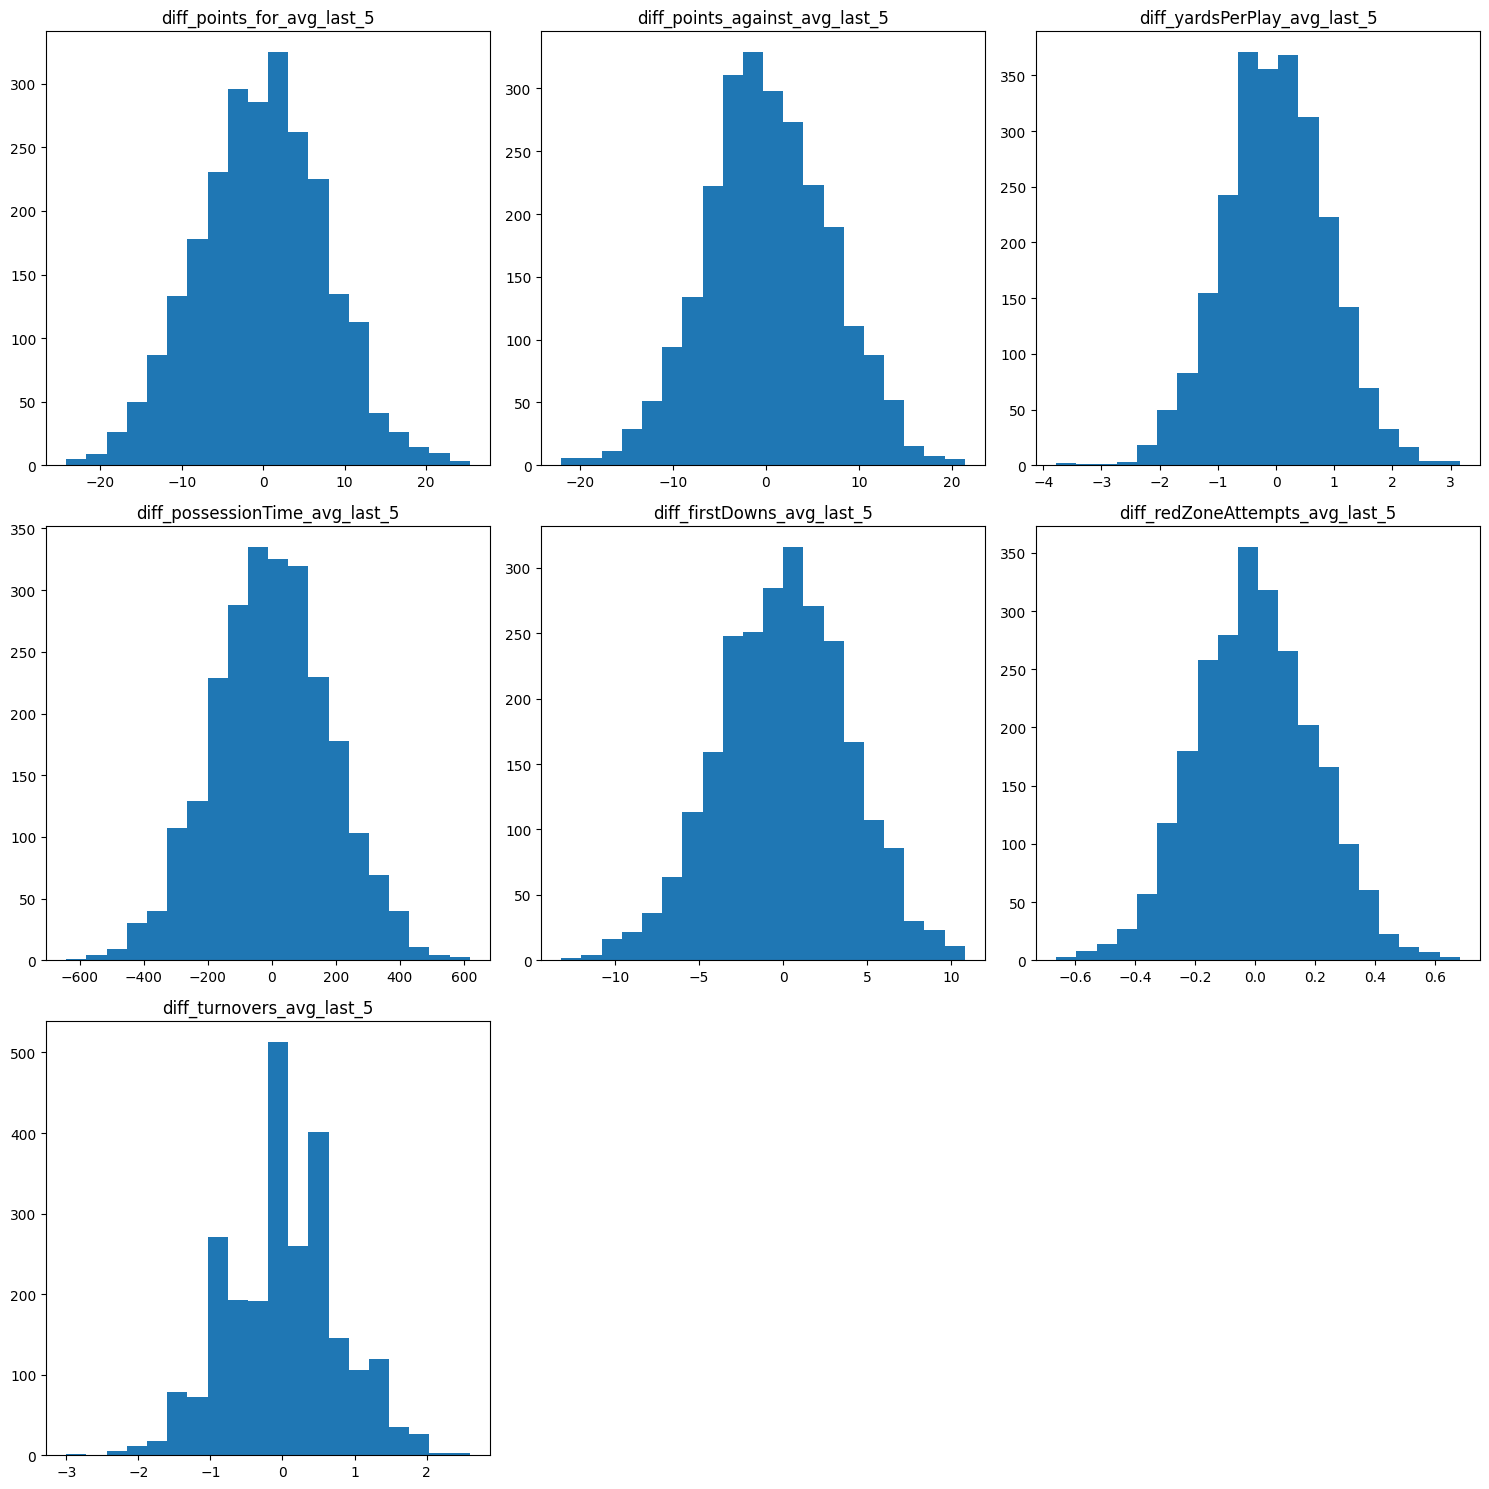

In [153]:
#distributions
num_features = len(feature_cols)
num_cols = 3
num_rows = math.ceil(num_features / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()

for i, col in enumerate(feature_cols):
  axes[i].hist(games_merged[col], bins=20)
  axes[i].set_title(col)

# Turn off any unused subplots
for j in range(i + 1, len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

All distributions are symmetric.

### Feature vs target relationship

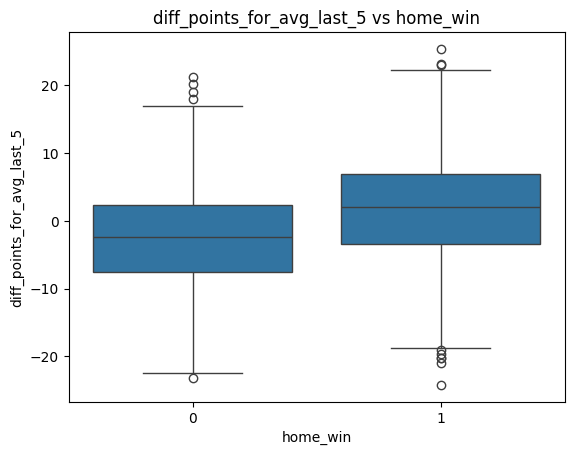

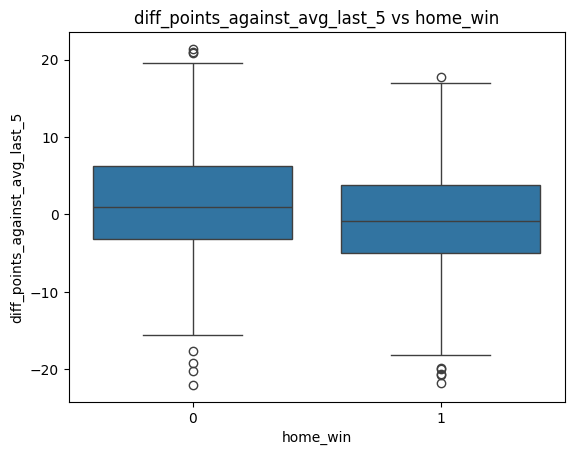

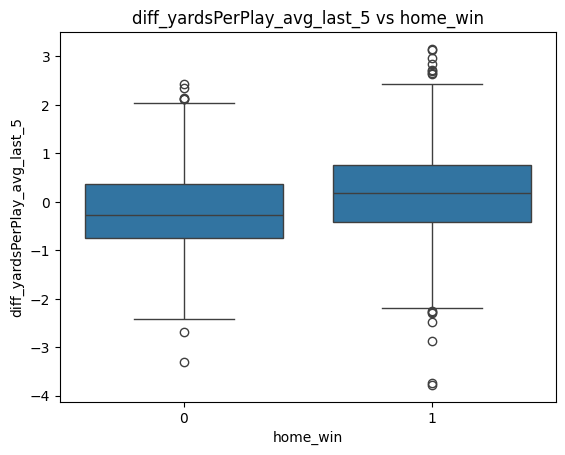

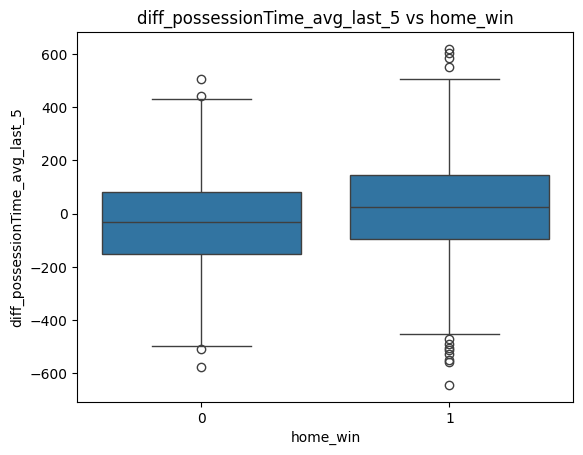

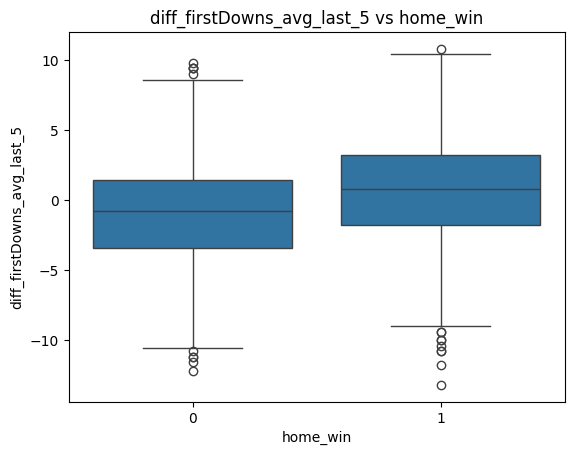

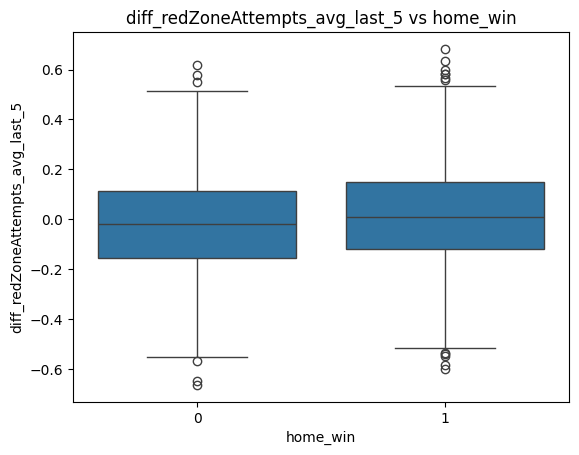

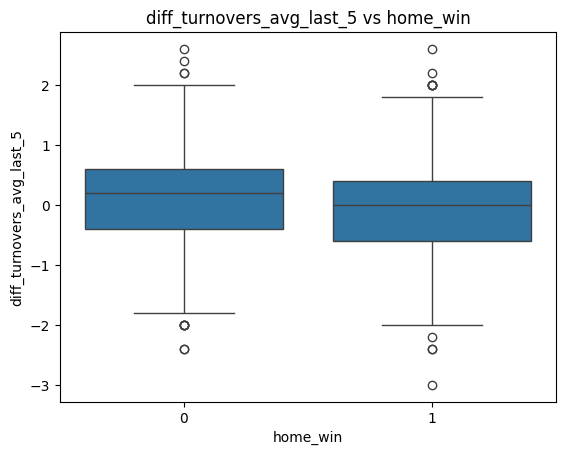

In [154]:
for col in feature_cols:
  sns.boxplot(x="home_win", y=col, data=games_merged)
  plt.title(f"{col} vs home_win")
  plt.show()

Home wins have a higher median for all feature columns, except for points_against and turnovers.

#### Correlation Analysis

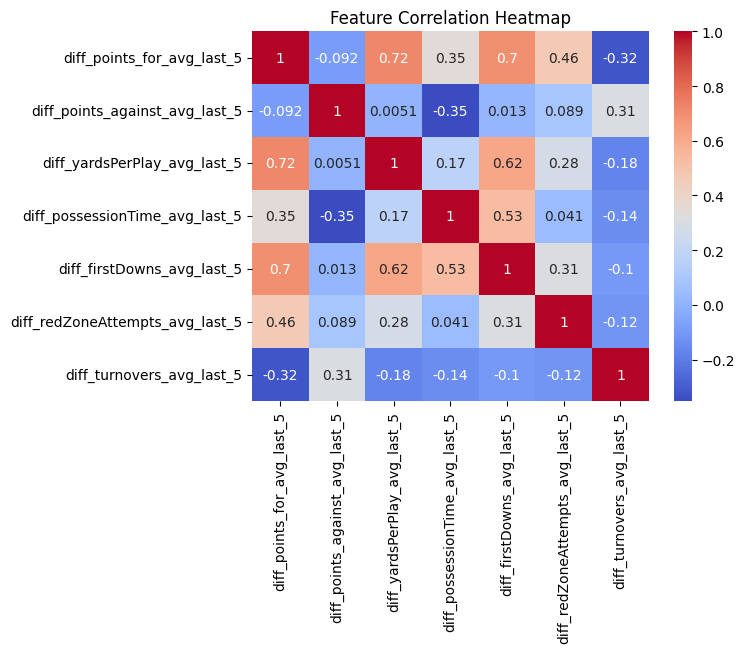

In [155]:
corr = games_merged[feature_cols].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

* Points scored by home team increases as Yards Per Play, Red Zone Attempts and Number of First Downs increase.
* Number of First Downs increase as Yards Per Play increase.
* Points conceded by the home team decrease as Possession Time increases.

All of these relationships are moderate.

In [156]:
#Feature-Target correlation
games_merged[feature_cols + ["home_win"]].corr()["home_win"].sort_values()


,home_win
diff_points_against_avg_last_5,-0.163353
diff_turnovers_avg_last_5,-0.127163
diff_redZoneAttempts_avg_last_5,0.082493
diff_possessionTime_avg_last_5,0.160951
diff_yardsPerPlay_avg_last_5,0.208948
diff_firstDowns_avg_last_5,0.220187
diff_points_for_avg_last_5,0.261329
home_win,1.000000


In [157]:
#Baseline Logistic Regression model

X = games_merged[feature_cols]
y = games_merged["home_win"]

model = LogisticRegression(max_iter=1000)
model.fit(X, y)

LogisticRegression(max_iter=1000)

In [158]:
pd.Series(
    model.coef_[0],
    index=feature_cols
).sort_values()

,0
diff_redZoneAttempts_avg_last_5,-0.205863
diff_turnovers_avg_last_5,-0.049709
diff_points_against_avg_last_5,-0.048254
diff_possessionTime_avg_last_5,-0.000027
diff_points_for_avg_last_5,0.044857
diff_firstDowns_avg_last_5,0.052003
diff_yardsPerPlay_avg_last_5,0.110371


### EDA Summary
* Conducted an initial review of dataset structure, data types, and summary statistics to understand data coverage and quality

* Identified and removed features with 100% missing values, as they provided no analytical or predictive value

* Observed a small number of missing values caused by rolling feature calculations at the beginning of each season, which is expected behavior

* Addressed remaining missing values by removing early-season rows with insufficient historical context

* Analyzed distributions of key performance metrics, including scoring, offensive efficiency, and play-level statistics

* Verified that most numerical features exhibited stable distributions without extreme outliers

* Engineered rolling average features to capture recent team form and short-term performance trends

* Evaluated correlations between engineered features and game results to guide feature selection

* Used insights from EDA to inform feature selection, preprocessing decisions, and downstream model design

## Modeling

In [159]:
#Sort data by time
games_merged = games_merged.sort_values("date").reset_index(drop=True)

In [160]:
#Time- based train-validation-testing split
train_df = games_merged[games_merged["season"]<=2022]
test_df = games_merged[games_merged["season"]>=2023]

In [161]:
train_df["season"].unique()

array([2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])

In [162]:
test_df["season"].unique()

array([2023, 2024, 2025])

This is approximately a 70-30 split. We cannot achieve exact split percentages as that would require splitting data from some seasons into separate sets, and we do not want that.

In [163]:
#Split into feature df and target df
X_train = train_df[feature_cols]
y_train = train_df[target]

X_test = test_df[feature_cols]
y_test = test_df[target]

In [164]:
#there should be no NaNs at this point
X_train.isna().sum().sum()

np.int64(0)

### Baseline Models

#### Elo Rating System
 Gives a sports-native baseline

In [166]:
roc_auc_score(games_merged["home_win"], games_merged["elo_home_win_prob"])

np.float64(0.64665517702965)

The baseline ROC-AUC here is **0.6482**. This measures how well a traditional sports rating system can rank game outcomes. A ROC-AUC of 0.6482 means that in **64.82%** of game pairs, the system correctly assigns higher win probability to the team that actually won.

In [167]:
log_loss(games_merged["home_win"], games_merged["elo_home_win_prob"])

0.6638384869215437

#### K-Fold Cross Validation

In [168]:
#Stratified K Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "roc_auc": "roc_auc",
    "log_loss": "neg_log_loss",
    "accuracy": "accuracy"
}

#### Logistic Regression

In [191]:
log_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        max_iter = 1000,
        solver = "lbfgs",
        random_state = 42
    ))
])

In [192]:
#cross-validation
log_cv = cross_validate(
    log_reg,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
)

print("Logistic Regression Cross-Validated ROC-AUC:", log_cv["test_roc_auc"].mean())
print("Logistic Regression Cross-Validated Log Loss:", -log_cv["test_log_loss"].mean())
print("Logistic Regression Cross-Validated Accuracy:",log_cv["test_accuracy"].mean())

Logistic Regression Cross-Validated ROC-AUC: 0.6726849955915356
Logistic Regression Cross-Validated Log Loss: 0.6445600275183881
Logistic Regression Cross-Validated Accuracy: 0.6284507042253521


ROC-AUC = 0.6727, which is good since it shows that this model is better than randomly assigning an outcome for each row of data.

#### Random Forest

In [173]:
rf = RandomForestClassifier(
    n_estimators = 300,
    max_depth = 8,
    min_samples_leaf = 10,
    random_state=42,
    n_jobs = -1
)

In [174]:
rf_cv = cross_validate(
    rf,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score = True
)
print("RF Cross-Validated ROC-AUC: ",rf_cv["test_roc_auc"].mean())
print("RF Cross-Validated Log Loss: ",-rf_cv["test_log_loss"].mean())
print("RF Cross-Validated Accuracy: ",rf_cv["test_accuracy"].mean())

RF Cross-Validated ROC-AUC:  0.6627522996885389
RF Cross-Validated Log Loss:  0.6504750234604431
RF Cross-Validated Accuracy:  0.6239499920873556


#### Gradient Boosting

In [175]:
gb = GradientBoostingClassifier(
    n_estimators = 200,
    learning_rate = 0.05,
    max_depth = 3,
    random_state = 42
)

In [176]:
gb_cv = cross_validate(
    gb,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True
)

print("GB Cross-Validated ROC-AUC:", gb_cv["test_roc_auc"].mean())
print("GB Cross-Validated Log Loss:", -gb_cv["test_log_loss"].mean())
print("GB Cross-Validated Accuracy: ",gb_cv["test_accuracy"].mean())

GB Cross-Validated ROC-AUC: 0.6346654677753445
GB Cross-Validated Log Loss: 0.6749853205629741
GB Cross-Validated Accuracy:  0.6008909637600887


#### XGBoost

In [177]:
xgb = XGBClassifier(
    n_estimators=300,
    max_depth = 3,
    learning_rate = 0.05,
    subsample = 0.7,
    colsample_bytree = 0.7,
    min_child_weight = 5,
    gamma=0.1,
    eval_metric="logloss",
    random_state=42
)


In [178]:
xgb_cv = cross_validate(
    xgb,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True
)

print("XGB Cross-Validated ROC-AUC:", xgb_cv["test_roc_auc"].mean())
print("XGB Cross-Validated Log Loss:", -xgb_cv["test_log_loss"].mean())
print("XGB Cross-Validated Accuracy: ",xgb_cv["test_accuracy"].mean())

XGB Cross-Validated ROC-AUC: 0.6424896514840073
XGB Cross-Validated Log Loss: 0.6712289317084377
XGB Cross-Validated Accuracy:  0.6031539800601362


In [179]:
results = []
results.append(["Logistic Regression",log_cv["test_roc_auc"].mean(),-log_cv["test_log_loss"].mean(),log_cv["test_accuracy"].mean()])
results.append(["Random Forest",rf_cv["test_roc_auc"].mean(),-rf_cv["test_log_loss"].mean(),rf_cv["test_accuracy"].mean()])
results.append(["Gradient Boosting",gb_cv["test_roc_auc"].mean(),-gb_cv["test_log_loss"].mean(),gb_cv["test_accuracy"].mean()])
results.append(["XGBoost",xgb_cv["test_roc_auc"].mean(),-xgb_cv["test_log_loss"].mean(),xgb_cv["test_accuracy"].mean()])

results_df = pd.DataFrame(results, columns=["Model", "ROC-AUC", "Log Loss", "Accuracy"])
results_df

,Model,ROC-AUC,Log Loss,Accuracy
0,Logistic Regression,0.672691,0.644555,0.628451
1,Random Forest,0.662752,0.650475,0.623950
2,Gradient Boosting,0.634665,0.674985,0.600891
3,XGBoost,0.642490,0.671229,0.603154


We can see that **Logistic Regression** is the clear winner out of all models here. We will now conduct hyperparameter tuning on this model. By doing so, we will identify the right amount and right kind of regularization so that the model generalizes best. By this process, we can also find out if hyperparameter tuning is actually required or not.

### Hyperparameter Tuning
Hyperparameter Tuning for Logistic Regression helps maximize predictive performance by optimizing key model parameters.

We can use the `GridSearchCV` technique here.

In [180]:
warnings.filterwarnings('ignore')

In [195]:
pipe = Pipeline([
    ("scaler",StandardScaler()),
    ("model",LogisticRegression(max_iter=1000, random_state=42))
])

param_grid = {
    "model__C": [0.01,0.1,1.0,10.0], #regularization parameter
    "model__penalty": ["l1","l2"], #L1 or L2 regularization; will likely get L2
    "model__solver": ["lbfgs","liblinear"] #solver for optimization
}

search = GridSearchCV(
    pipe,
    param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs = -1
)

search.fit(X_train, y_train)

print("Best CV ROC-AUC: ",search.best_score_)
print("Best Parameters: ",search.best_params_)

Best CV ROC-AUC:  0.6750914500847731
Best Parameters:  {'model__C': 0.1, 'model__penalty': 'l1', 'model__solver': 'liblinear'}


We marginally increase the ROC-AUC Score.

In [196]:
#retrain on full training data
best_logreg = search.best_estimator_
best_logreg.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=0.1, max_iter=1000, penalty='l1',
                                    random_state=42, solver='liblinear'))])

In [197]:
#evaluation on test set
test_preds = best_logreg.predict(X_test)
test_probs = best_logreg.predict_proba(X_test)[:,1]

print("Test ROC-AUC: ",roc_auc_score(y_test, test_probs))
print("Test Log Loss: ",log_loss(y_test, test_probs))
print("Test Accuracy: ",accuracy_score(y_test, test_preds))

Test ROC-AUC:  0.6709115814590606
Test Log Loss:  0.6439619761235447
Test Accuracy:  0.6331360946745562


For the final Logistic Regression model, we get the following evaluation metrics:
* Test ROC-AUC:  0.6709
* Test Log Loss:  0.6440
* Test Accuracy:  0.6331

In [199]:
coef = best_logreg.named_steps["model"].coef_[0]

coeff_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": coef
}).assign(abs_coef = lambda df: df["Coefficient"].abs()).sort_values("abs_coef",ascending=False)

coeff_df

,Feature,Coefficient,abs_coef
0,diff_points_for_avg_last_5,0.297049,0.297049
1,diff_points_against_avg_last_5,-0.249323,0.249323
4,diff_firstDowns_avg_last_5,0.166064,0.166064
2,diff_yardsPerPlay_avg_last_5,0.112790,0.112790
6,diff_turnovers_avg_last_5,-0.111897,0.111897
3,diff_possessionTime_avg_last_5,0.030290,0.030290
5,diff_redZoneAttempts_avg_last_5,0.000000,0.000000


The features that cause the most change in the predictions of the outcome are:
* points_for
* points_against
* firstDowns

### Deployment

In [203]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [204]:
joblib.dump(best_logreg,"nfl_win_model.pkl")
joblib.dump(scaler,"nfl_scaler.pkl")

['nfl_scaler.pkl']